# 📰 Fake News Classifier — Complete Jupyter Notebook

## 1) Data Loading & Initial Exploration

In [ ]:
import pandas as pd
import numpy as np
import sys

data_fake = pd.read_csv('Fake.csv', on_bad_lines='skip', engine='python')
data_true = pd.read_csv('True.csv', on_bad_lines='skip', engine='python')


# Add label column: 1 -> Fake, 0 -> True
data_fake = data_fake.copy()
data_true = data_true.copy()

data_fake['label'] = 1
data_true['label'] = 0

# Combine
data = pd.concat([data_fake, data_true], ignore_index=True)

# Quick look
print('Combined shape:', data.shape)
print('\nColumns:', data.columns.tolist())

# Basic info
print('\nInfo:')
print(data.info())

# Describe
print('\nDescribe (object columns):')
print(data.describe(include=[object]).T)

# Check nulls
print('\nNull values per column:')
print(data.isnull().sum())

Combined shape: (23459, 5)

Columns: ['title', 'text', 'subject', 'date', 'label']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23459 entries, 0 to 23458
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23459 non-null  object
 1   text     23459 non-null  object
 2   subject  23459 non-null  object
 3   date     23459 non-null  object
 4   label    23459 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 916.5+ KB
None

Describe (object columns):
         count unique                                                top  freq
title    23459  19637  MEDIA IGNORES Time That Bill Clinton FIRED His...     6
text     23459  19197                                                      608
subject  23459      5                                               News  9050
date     23459   1855                                 November 30, 2017     45

Null values per column:
title      0
text       0
subject    0

### Class distribution

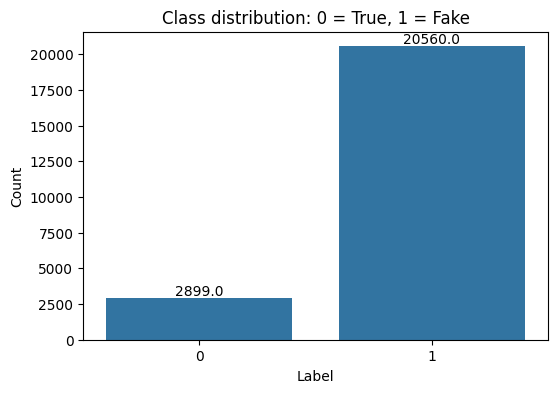


Class distribution (%):
label
1    87.642269
0    12.357731
Name: proportion, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data)
plt.title('Class distribution: 0 = True, 1 = Fake')
plt.xlabel('Label')
plt.ylabel('Count')
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height}', (p.get_x()+p.get_width()/2., height), ha='center', va='bottom')
plt.show()

# Show percentages
print('\nClass distribution (%):')
print(data['label'].value_counts(normalize=True)*100)

### 2) Exploratory Data Analysis (EDA)
### We'll inspect the text columns (`title`, `text`), show sample entries, and visualize word clouds (if installed).

In [ ]:
# Show few rows
display(data.sample(6).T)

,5137,16320,15384,4032,7401,9207
title,Muslim Olympian Takes Gold Medal Jab At ‘Dang...,BEGGIN’ MEGYN KELLY’S New Book Ripped To Shrea...,ZIMBABWE’S CORRUPT GOVERNMENT SEEKS EXTRADITIO...,WATCH: Anderson Cooper And Ana Navarro NAIL H...,Obama Infuriates GOP By Proving Cubans Are No...,DOCTOR MENTIONED In Hillary Email Released By ...
text,Ibtihaj Muhammad is on the Olympic fencing tea...,Megyn Kelly started out like a shooting star a...,So much outrage by so many corrupt people it s...,Newt Gingrich must really be regretting his li...,Conservatives love to portray Cuba as an unvit...,"54-year-old Dr. Dean Lorich, Associate Directo..."
subject,News,Government News,politics,News,News,politics
date,"August 8, 2016","Nov 16, 2016","Jul 31, 2015","October 27, 2016","March 19, 2016","Dec 13, 2017"
label,1,1,1,1,1,1


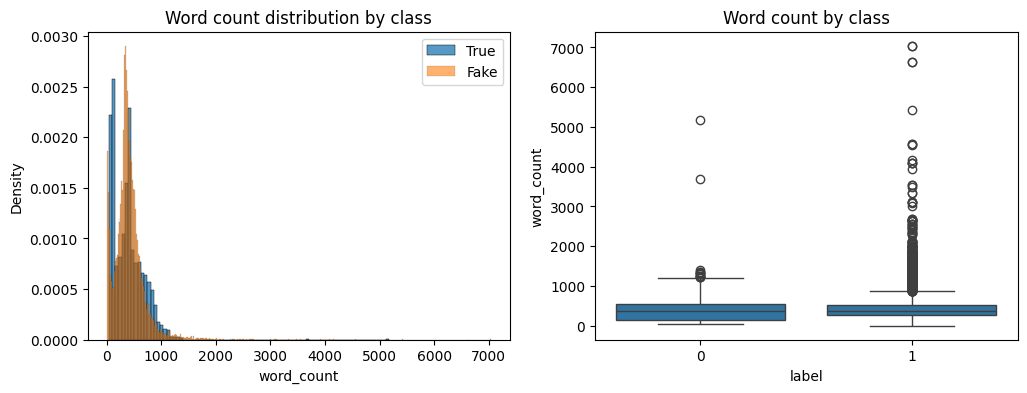

In [ ]:
# Basic length features to inspect distribution
if 'text' not in data.columns:
    # Some Fake/True datasets use different column names; try 'content' or combine title+text
    print("Warning: 'text' column not found. Available columns:", data.columns.tolist())

# Create combined text column for analysis
data['content'] = data.apply(lambda r: (str(r.get('title','')) + ' ' + str(r.get('text',''))).strip(), axis=1)

# Add simple numeric features
data['content_length'] = data['content'].apply(lambda x: len(x))
data['word_count'] = data['content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data[data['label']==0]['word_count'], label='True', kde=False, stat='density')
sns.histplot(data[data['label']==1]['word_count'], label='Fake', kde=False, stat='density', alpha=0.6)
plt.legend()
plt.title('Word count distribution by class')

plt.subplot(1,2,2)
sns.boxplot(x='label', y='word_count', data=data)
plt.title('Word count by class')
plt.show()

### Try generating word clouds (optional). If `wordcloud` is not installed, this step will be skipped gracefully.

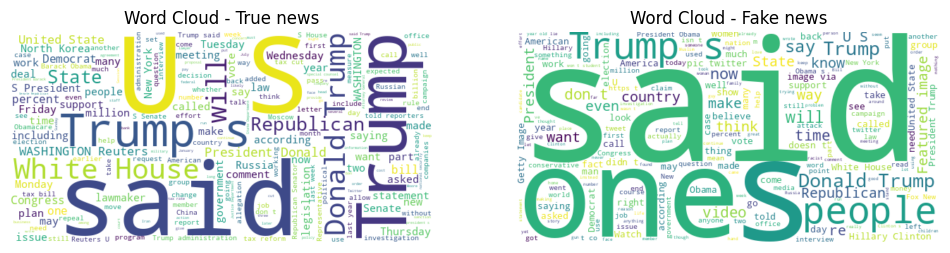

In [ ]:
try:
    from wordcloud import WordCloud
    wc_true = WordCloud(width=600, height=300, background_color='white').generate(' '.join(data[data['label']==0]['content'].astype(str).tolist()))
    wc_fake = WordCloud(width=600, height=300, background_color='white').generate(' '.join(data[data['label']==1]['content'].astype(str).tolist()))

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(wc_true, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - True news')

    plt.subplot(1,2,2)
    plt.imshow(wc_fake, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Fake news')
    plt.show()
except Exception as e:
    print('Skipping word cloud (wordcloud library may not be installed).', e)

### 3) Text Preprocessing
###  We'll clean text: remove URLs, special characters, extra spaces, lowercase, remove stopwords, lemmatize.
###  We'll show before/after examples.

In [ ]:


# Preprocessing utilities imports
import re
import nltk

# Download required NLTK data (wrapped in try/except)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('tokenizers/punkt_tab') # Add this line to download 'punkt_tab'
except LookupError:
    nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Define preprocessing function

def preprocess_text(text, do_lemmatize=True, remove_stopwords=True):
    """Clean and tokenize text: remove urls, non-alphanumeric chars, lower, remove stopwords, lemmatize."""
    if pd.isnull(text):
        return ''
    # convert to str
    text = str(text)
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # keep only letters and numbers
    text = re.sub(r"[^a-zA-Z0-9\s]", ' ', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # lowercase
    text = text.lower()
    # tokenize
    tokens = word_tokenize(text)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words and len(t)>1]
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

In [ ]:
# Show before/after examples on a few samples
samples = data['content'].sample(6, random_state=42).tolist()
print('Before -> After')
for s in samples:
    print('---')
    print('BEFORE:', s[:200])
    print('AFTER :', preprocess_text(s)[:200])

Before -> After
---
BEFORE: BREAKING VIDEO Of Hillary Supporter And #BlackLivesMatter Activist Vandalizing Trump’s Brand New DC Hotel [VIDEO] Hillary has been stirring up the hateful movement Obama, Eric Holder and Al Sharpton s
AFTER : breaking video hillary supporter blacklivesmatter activist vandalizing trump brand new dc hotel video hillary stirring hateful movement obama eric holder al sharpton started year ago mean encourage bl
---
BEFORE: The Internet Loses It Over RNC’s Bizarre Statement About A ‘New King’ (TWEETS) The Republican National Committee released a bizarre Christmas statement comparing president-elect Donald Trump to a  Kin
AFTER : internet loses rnc bizarre statement new king tweet republican national committee released bizarre christmas statement comparing president elect donald trump king recall time conservative mocked presi
---
BEFORE: BLOGGER Comes Clean About Hannity Sexual Harassment Claim…Hannity’s Former Producer Publicly Calls Her Out On LIE About Why She 

In [ ]:
# Apply preprocessing to the dataset (this may take some time)

data['content_clean'] = data['content'].apply(lambda x: preprocess_text(x))

# Check nulls and sample cleaned
print('\nAfter cleaning — any empty contents?', (data['content_clean'].str.strip()=="").sum())
print('\nSample cleaned text:')
print(data[['content','content_clean']].sample(6).T)


After cleaning — any empty contents? 7

Sample cleaned text:
                                                           2992   \
content        Republicans Are Working To Make It LEGAL To In...   
content_clean  republican working make legal injure kill prot...   

                                                           19363  \
content        BUH-BYE MEGYN…The Woman Who Miscalculated Her ...   
content_clean  buh bye megyn woman miscalculated power viewer...   

                                                           9525   \
content        PBS FORCED TO Shut Down LIVE Event For Hillary...   
content_clean  pb forced shut live event hillary clinton face...   

                                                           11762  \
content        VOTE THEM OUT! SIX SENATE DEMOCRATS Up For Ree...   
content_clean  vote six senate democrat reelection red state ...   

                                                           6236   \
content        Trump Took Federal Money Meant For 

### 4) Feature Engineering
###  TF-IDF (with unigrams and bigrams) and simple numeric features like text length and punctuation count.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Additional simple features
import string

def punctuation_count(s):
    if pd.isnull(s):
        return 0
    return sum(1 for ch in s if ch in string.punctuation)

# create features
data['punct_count'] = data['content'].apply(punctuation_count)
# content_length and word_count already exist

# Define TF-IDF vectorizer (unigrams + bigrams)
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3)

# Fit-transform on cleaned content
X_tfidf = vectorizer.fit_transform(data['content_clean'].astype(str))
print('TF-IDF matrix shape:', X_tfidf.shape)

# Combine sparse TF-IDF with numeric features using scipy hstack
from scipy.sparse import hstack, csr_matrix

numeric_feats = csr_matrix(data[['content_length','word_count','punct_count']].fillna(0).values)
X = hstack([X_tfidf, numeric_feats])

# Labels
y = data['label'].values

print('Final feature matrix shape:', X.shape)

TF-IDF matrix shape: (23459, 20000)
Final feature matrix shape: (23459, 20003)


### 5) Train / Test Split
###  We'll use an 80-20 split and stratify by label. We'll create helper functions for training and evaluation.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (18767, 20003) Test shape: (4692, 20003)


#### Helper functions: training, evaluation and plotting

In [ ]:
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, model, X_test, y_test, y_pred_proba=None):
    """Evaluate model and return metrics dict. Also plot confusion matrix and ROC curve."""
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cls_report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Print summary
    print(f"\nModel: {name}")
    print('Accuracy:', acc)
    print('\nClassification report:')
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC & AUC — try to obtain probability scores or decision function
    auc = None
    if y_pred_proba is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc = roc_auc_score(y_test, y_pred_proba)
            plt.figure(figsize=(6,4))
            plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
            plt.plot([0,1],[0,1],'--')
            plt.title(f'ROC Curve - {name}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()
        except Exception:
            print('Could not compute ROC/AUC for', name)

    return {'name': name, 'accuracy': acc, 'report': cls_report, 'confusion_matrix': cm, 'auc': auc}

# A generic train function that times the training

def train_and_time(model, X_train, y_train):
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    return model, end-start

### 6) Models — train and evaluate each model in its own cell

#### 6.1 Linear Regression (baseline)
#### We'll treat labels as 0/1, train LinearRegression and threshold predictions at 0.5 to get class labels.

Training time (s): 0.5419011116027832
Accuracy (threshold 0.5): 0.9963768115942029

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       580
           1       1.00      1.00      1.00      4112

    accuracy                           1.00      4692
   macro avg       0.99      0.99      0.99      4692
weighted avg       1.00      1.00      1.00      4692



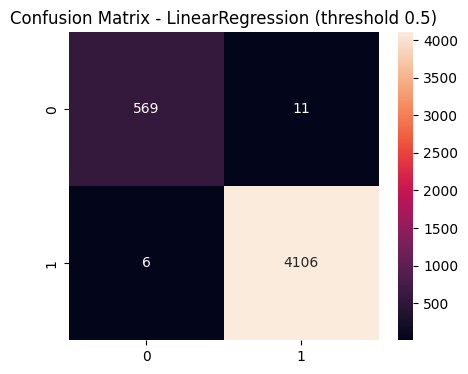

AUC: 0.9994486280692338


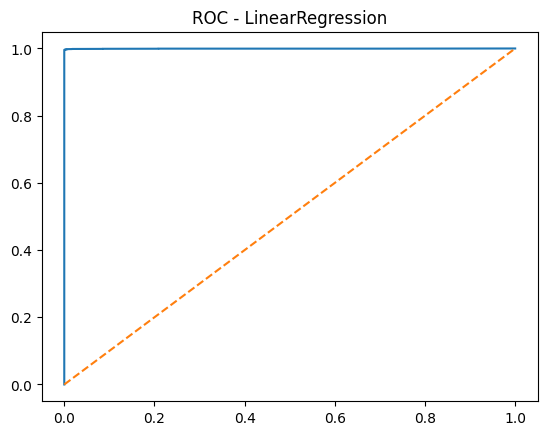

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg, t_lin = train_and_time(linreg, X_train, y_train)
# Predict continuous outputs and threshold
y_pred_cont = linreg.predict(X_test)
# convert to probabilities in 0-1 via clipping
y_pred_prob = np.clip(y_pred_cont, 0, 1)
# threshold
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# Evaluate
from sklearn.metrics import accuracy_score
print('Training time (s):', t_lin)
print('Accuracy (threshold 0.5):', accuracy_score(y_test, y_pred_label))
print('\nClassification report:')
print(classification_report(y_test, y_pred_label))
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix - LinearRegression (threshold 0.5)')
plt.show()

# ROC/AUC
try:
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    print('AUC:', roc_auc_score(y_test, y_pred_prob))
    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title('ROC - LinearRegression'); plt.show()
except Exception as e:
    print('ROC failed:', e)

results = []
results.append({'name':'LinearRegression','accuracy':accuracy_score(y_test,y_pred_label),'auc':roc_auc_score(y_test,y_pred_prob)})

#### 6.2 Logistic Regression

Training time (s): 30.988640785217285

Model: Logistic Regression
Accuracy: 0.9865728900255755

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       580
           1       0.99      1.00      0.99      4112

    accuracy                           0.99      4692
   macro avg       0.99      0.95      0.97      4692
weighted avg       0.99      0.99      0.99      4692



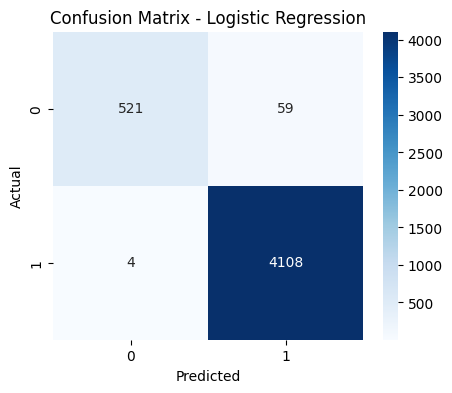

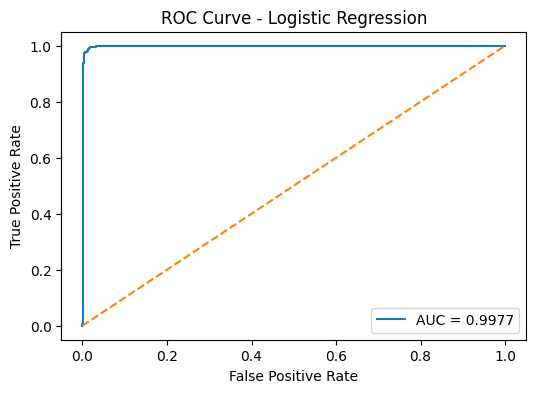

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg, t_log = train_and_time(logreg, X_train, y_train)
print('Training time (s):', t_log)
# Predict
y_proba_log = None
try:
    y_proba_log = logreg.predict_proba(X_test)[:,1]
except Exception:
    y_proba_log = logreg.decision_function(X_test)

res_log = evaluate_model('Logistic Regression', logreg, X_test, y_test, y_proba_log)
res_log['train_time_s'] = t_log
results.append(res_log)

#### 6.3 Multinomial Naive Bayes
##### Note: MultinomialNB expects non-negative features (TF-IDF is fine)

Training time (s): 0.053466796875

Model: MultinomialNB
Accuracy: 0.9477834612105712

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       580
           1       0.95      0.99      0.97      4112

    accuracy                           0.95      4692
   macro avg       0.94      0.81      0.86      4692
weighted avg       0.95      0.95      0.94      4692



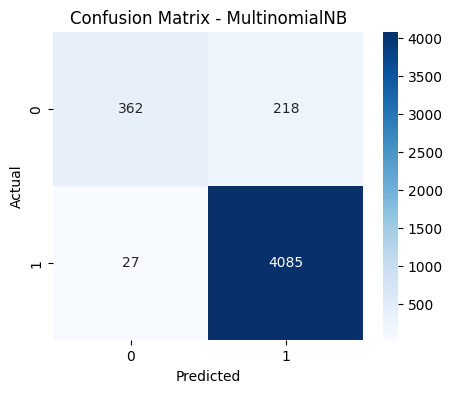

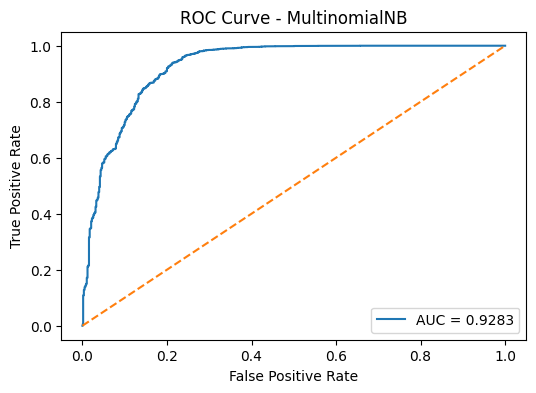

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb, t_mnb = train_and_time(mnb, X_train, y_train)
print('Training time (s):', t_mnb)
try:
    y_proba_mnb = mnb.predict_proba(X_test)[:,1]
except Exception:
    y_proba_mnb = None
res_mnb = evaluate_model('MultinomialNB', mnb, X_test, y_test, y_proba_mnb)
res_mnb['train_time_s'] = t_mnb
results.append(res_mnb)

#### 6.4 Random Forest Classifier

Training time (s): 31.144673109054565

Model: Random Forest
Accuracy: 0.9961636828644501

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       580
           1       1.00      1.00      1.00      4112

    accuracy                           1.00      4692
   macro avg       1.00      0.99      0.99      4692
weighted avg       1.00      1.00      1.00      4692



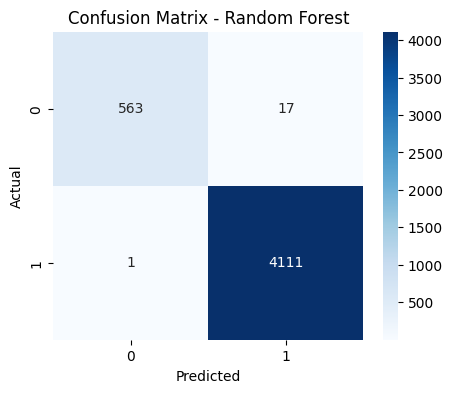

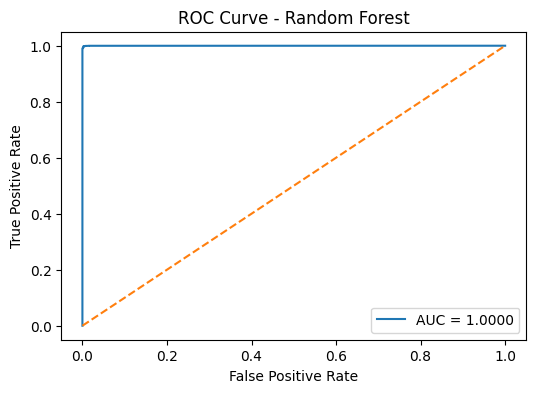


Top 10 feature importances (indices): [14531 19221 13226 19214 14942 14539 18893 18836 14308  6275]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rfc, t_rfc = train_and_time(rfc, X_train, y_train)
print('Training time (s):', t_rfc)
try:
    y_proba_rfc = rfc.predict_proba(X_test)[:,1]
except Exception:
    y_proba_rfc = None
res_rfc = evaluate_model('Random Forest', rfc, X_test, y_test, y_proba_rfc)
res_rfc['train_time_s'] = t_rfc
results.append(res_rfc)

# Feature importance: since features are high-dimensional (TF-IDF + 3 numeric), show top numeric importances only by averaging groups
try:
    importances = rfc.feature_importances_
    # Show top 10 importances indexes
    top_idx = np.argsort(importances)[-10:][::-1]
    print('\nTop 10 feature importances (indices):', top_idx)
except Exception as e:
    print('Could not compute feature importances: ', e)

#### 6.5 Support Vector Machine (SVM)
##### We'll use a linear SVM for speed (LinearSVC) but enable probability via CalibratedClassifierCV if needed.

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training time (s): 479.0214955806732

Model: LinearSVC (Calibrated)
Accuracy: 0.9377664109121909

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70       580
           1       0.94      0.99      0.97      4112

    accuracy                           0.94      4692
   macro avg       0.91      0.78      0.83      4692
weighted avg       0.94      0.94      0.93      4692



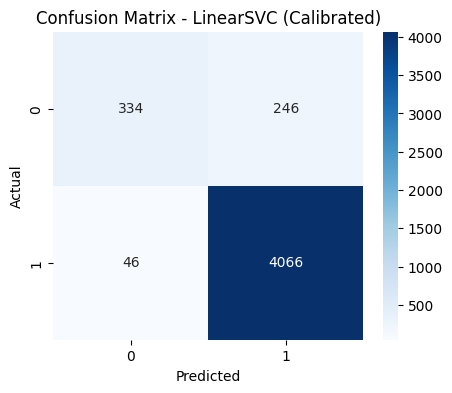

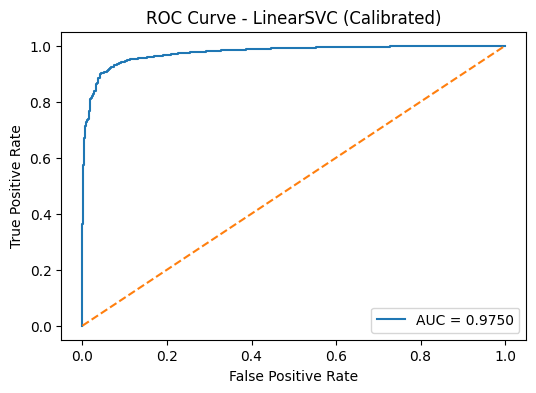

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC(max_iter=5000)
# Wrap with calibration to get probabilities (this will take longer)
svc_cal = CalibratedClassifierCV(svc)
svc_cal, t_svc = train_and_time(svc_cal, X_train, y_train)
print('Training time (s):', t_svc)
try:
    y_proba_svc = svc_cal.predict_proba(X_test)[:,1]
except Exception:
    y_proba_svc = None
res_svc = evaluate_model('LinearSVC (Calibrated)', svc_cal, X_test, y_test, y_proba_svc)
res_svc['train_time_s'] = t_svc
results.append(res_svc)

#### 6.6 Gradient Boosting (sklearn)

Training time (s): 390.204519033432

Model: GradientBoosting
Accuracy: 0.9982949701619779

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       580
           1       1.00      1.00      1.00      4112

    accuracy                           1.00      4692
   macro avg       0.99      1.00      1.00      4692
weighted avg       1.00      1.00      1.00      4692



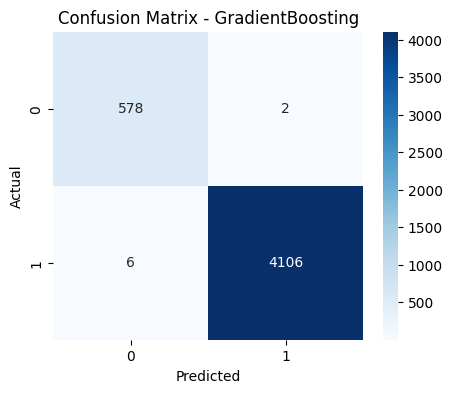

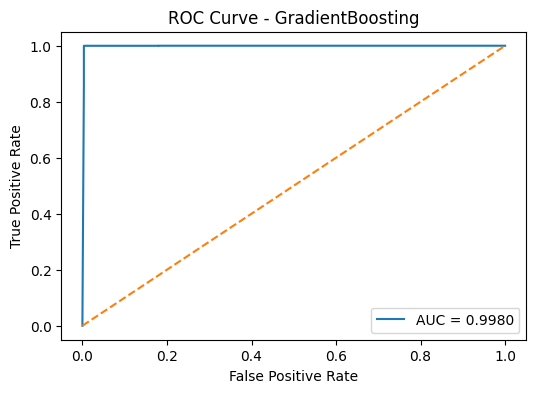

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb, t_gb = train_and_time(gb, X_train, y_train)
print('Training time (s):', t_gb)
try:
    y_proba_gb = gb.predict_proba(X_test)[:,1]
except Exception:
    y_proba_gb = None
res_gb = evaluate_model('GradientBoosting', gb, X_test, y_test, y_proba_gb)
res_gb['train_time_s'] = t_gb
results.append(res_gb)

### 7) Cross-validation (optional but recommended)
#### We'll perform cross-validation on the Logistic Regression and Random Forest to estimate stability.

In [ ]:
from sklearn.model_selection import cross_val_score

print('Cross-validating Logistic Regression (5-fold):')
cv_scores_log = cross_val_score(logreg, X, y, cv=5, scoring='f1')
print('5-fold F1 scores:', cv_scores_log)
print('Mean F1:', cv_scores_log.mean())

print('\nCross-validating Random Forest (3-fold due to time):')
cv_scores_rf = cross_val_score(rfc, X, y, cv=3, scoring='f1')
print('3-fold F1 scores:', cv_scores_rf)
print('Mean F1:', cv_scores_rf.mean())

Cross-validating Logistic Regression (5-fold):


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

5-fold F1 scores: [0.9911889  0.99179932 0.98913831 0.98652875 0.9908146 ]
Mean F1: 0.9898939744928729

Cross-validating Random Forest (3-fold due to time):
3-fold F1 scores: [0.99658256 0.9966526  0.9951979 ]
Mean F1: 0.9961443554065171


### 8) Comparison & Visualization of Model Performance

                    Model  Accuracy       AUC  TrainTime_s
0        GradientBoosting  0.998295  0.998000   390.204519
1        LinearRegression  0.996377  0.999449          NaN
2           Random Forest  0.996164  0.999956    31.144673
3     Logistic Regression  0.986573  0.997720    30.988641
4           MultinomialNB  0.947783  0.928274     0.053467
5  LinearSVC (Calibrated)  0.937766  0.975025   479.021496


/tmp/ipython-input-550858485.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=comp_df, palette='deep')
/tmp/ipython-input-550858485.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AUC', y='Model', data=comp_df, palette='muted')


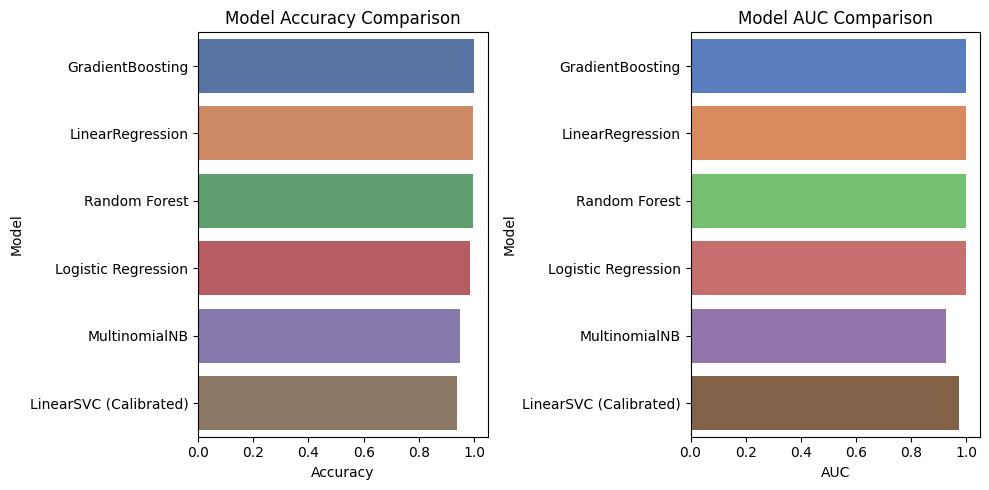


Best by accuracy:
 Model          GradientBoosting
Accuracy               0.998295
AUC                       0.998
TrainTime_s          390.204519
Name: 0, dtype: object


In [ ]:
# Build comparison table from results list

rows = []
for r in results:
    if isinstance(r, dict):
        rows.append({'Model': r.get('name','unknown'), 'Accuracy': r.get('accuracy'), 'AUC': r.get('auc'), 'TrainTime_s': r.get('train_time_s', None)})
    else:
        rows.append(r)

comp_df = pd.DataFrame(rows).sort_values('Accuracy', ascending=False).reset_index(drop=True)
print(comp_df)

# Bar chart comparison
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(x='Accuracy', y='Model', data=comp_df, palette='deep')
plt.title('Model Accuracy Comparison')

plt.subplot(1,2,2)
sns.barplot(x='AUC', y='Model', data=comp_df, palette='muted')
plt.title('Model AUC Comparison')
plt.tight_layout()
plt.show()

# Identify best performing model by Accuracy then AUC
best_by_acc = comp_df.loc[comp_df['Accuracy'].idxmax()]
print('\nBest by accuracy:\n', best_by_acc)

### 9) Save best model and vectorizer for deployment (optional)
#### We will save the best model (by accuracy) and the TF-IDF vectorizer using joblib. If you prefer pickle, change accordingly.

In [ ]:
import joblib

best_model_name = comp_df.loc[comp_df['Accuracy'].idxmax()]['Model']
print('Best model name:', best_model_name)

# Map name -> actual model object
model_map = {
    'Logistic Regression': logreg,
    'MultinomialNB': mnb,
    'Random Forest': rfc,
    'LinearSVC (Calibrated)': svc_cal,
    'GradientBoosting': gb
}

best_model = model_map.get(best_model_name, None)
if best_model is not None:
    joblib.dump(best_model, 'best_model.joblib')
    joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
    print('Saved best_model.joblib and tfidf_vectorizer.joblib')
else:
    print('Best model object not found in model_map. Please save manually if needed.')

Best model name: GradientBoosting
Saved best_model.joblib and tfidf_vectorizer.joblib


### 10) Utilities & Inference Example
#### A small function to preprocess and predict on a single text example.

In [ ]:
def predict_text_raw(text, model, vectorizer):
    """Return predicted label and probability for a single raw text string."""
    clean = preprocess_text(text)
    X_vec = vectorizer.transform([clean])
    # add numeric features (zeros for single sample)
    numerics = np.array([[len(text), len(text.split()), punctuation_count(text)]])
    from scipy.sparse import hstack
    X_full = hstack([X_vec, csr_matrix(numerics)])
    try:
        proba = model.predict_proba(X_full)[:,1][0]
    except Exception:
        # try decision function
        try:
            proba = model.decision_function(X_full)
            # scale to 0-1
            proba = 1/(1+np.exp(-proba))[0]
        except Exception:
            proba = None
    pred = model.predict(X_full)[0]
    return {'predicted_label': int(pred), 'probability': float(proba) if proba is not None else None}

# Example usage (replace text below with any article text)
example_text = "Breaking: New discovery shows dramatic impact on climate. Experts are shocked by findings."
print('Inference example:', predict_text_raw(example_text, logreg, vectorizer))

Inference example: {'predicted_label': 1, 'probability': 0.9743748105837245}


#### Notes, Best Practices & Next Steps

#### Performance Improvements
- Apply hyperparameter tuning using techniques like `GridSearchCV` or `RandomizedSearchCV`.
- Explore advanced text representations such as word embeddings or transformer-based embeddings.
- Consider ensembling predictions from multiple models to boost accuracy.

#### Reproducibility
- Set `random_state` consistently across models and data splits to ensure reproducible results.

#### Production Considerations
- Use a smaller vocabulary or a hashing vectorizer to reduce memory usage in deployment environments.
- Incorporate additional metadata features (e.g., source, author, publish date) if available to enhance model performance.

---

**End of notebook**

If you want this converted to a `.ipynb` file, I can prepare it for download in the next response.